# K_Neghboors

[Link to the github repository](https://github.com/rw404/IML/blob/master/K_means.ipynb)

# Table of contents

- [Libraries](#libs)
- [K_means](#start)
    - [1st task](#1st)
        - [Centres](#init)
            - [k_means++](#k++)
            - [k_means(random)](#kms)
            - [k_max](#kmax)
        - [Clustering functions](#clsfunc)
        - [All in one function](#resfunc)
        - [Samples](#samples)
            - [Default rnadom](#default)
            - [Normal random](#normal)
    - [2nd task](#2nd)
        - [Incorrect clustering](#incorrect)
            - [K_means_plus_plus](#k++err)
            - [K_max](#kmerr)
            - [K_means](#kerr)
        - [Correct clustering](#correct)
    - [3rd task](#3rd)
    - [4th task](#4th)
        - [Time(num of elements](#te)
        - [Time(num of clusters)](#tc)
    - [5th task](#5th)
        - [Elements](#elar)
        - [Default matrix](#def)
        - [Matrix after clustering](#aftcl)
            - [Sorting function](#sf)
        - [Sorted clusters dist matrix](#ascl)
            - [Sorting clusters](#sort)

## Libraries <a id="libs"></a>

In [197]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## K_means <a id="start"></a>

---
## 1-ое задание (зависимость от инициаллизации) <a id="1st"></a>
---

### Centres initiallization <a id = "init"></a>

#### K_means++ initiallization <a id = "k++"></a>

In [198]:
def k_means_plus_plus(elements, k = 2):
    #choosing a random array element as the 1st center
    new_start_ind = np.random.choice(np.arange(elements.shape[0]))
    centres = np.zeros((k, elements.shape[1]))
    centres[0] = np.array(elements[new_start_ind])
    for l in range(k-1):
        #norms array -- dx^2
        dif = np.zeros(elements.shape[0])
        for i in range(elements.shape[0]):
            dif[i] = np.linalg.norm(elements[i] - centres[0], ord = 2)
            j = l
            while j >= 0:
                dif[j] = min(np.linalg.norm(elements[i] - centres[j], ord = 2), dif[j])
                j = j - 1
        #summ of norms array -- S(dx^2)
        summ = np.sum(dif, axis = 0)
        #random element from [0, summ)
        rnd = np.random.random(size = 1) * summ
        #while temp_summ < summ: temp_sum += d(x_i)^2
        tmp = 0
        for i in range(elements.shape[0]):
            tmp = tmp + dif[i]
            #if temp_summ >= summ: next centre = elements[i]
            if tmp >= rnd:
                centres[l+1] = np.array(elements[i])
                break
    return centres

#### K_means initiallization (random array elements) <a id ="kms"></a>

In [199]:
def k_means(elements, k = 2):
    #random elements from input array
    #choosing indexes
    mas = np.random.choice(elements.shape[0], size = k, replace = True)
    #choosing elements
    centres = np.zeros((k, elements.shape[1]))
    for i in range(k):
        centres[i] = np.array(elements[mas[i]])
    return centres

#### K_max initiallization (the next one is the furthest form the previous one) <a id ="kmax"></a>

Реализиовать идею векторных преобразований для получения матрицы расстояний не получилось, поскольку в примере было 10000 элементов, а это число примерно равно 1,5 ГБ памяти(хоть и автоматической), поэтому функция `difers()` сработает только, если число элеметов будет не больше 1000.

Но тогда для нахождения самого удаленного элемента используется рассуждение, что если нужно расстояние от i-го до j-го элемента, то можно вопсользоваться предположением, что хоть и `||elements[i]-elements[j]|| <= ||elements[i] - elements[0]|| + ||elements[j]-elements[0]||`, но разность этих величин есть о-малое от левой части неравенства.

In [118]:
def difers(elements):
    return np.sqrt(((elements[:,None,:] - elements)**2).sum(axis=2))

In [119]:
def k_max(elements, k = 2):
    #default initiallization
    centres = np.zeros((k, elements.shape[1]))
    #first center is a random element from input array
    start = np.random.choice(elements.shape[0])
    centres[0] = np.array(elements[start])
    #list of centres indexes
    indexes = [start,]
    #distances array
    difs = np.zeros(elements.shape[0])
    for i in range(elements.shape[0]):
        difs[i] = np.linalg.norm(centres[0] - elements[i], ord=2)
    #choosing the furthest from the previous one
    for i in range(1, k):
        max_dist = 0
        max_ind = 0
        for j in range(elements.shape[0]):
            #distance between i and j is |difs[i]-difs[j]|
            if np.abs(difs[j]-difs[start]) > max_dist and j not in indexes:
                max_dist = np.abs(difs[j]-difs[start])
                max_ind = j
        #current center is previous for next iterarion
        start = max_ind
        indexes.append(start)
        centres[i] = np.array(elements[max_ind])
    return centres

### Clustering function <a id = "clsfunc"></a>

In [120]:
def k_neigbs(elements, k = 5, init = "k_means"):
    #initiallization
    if init == "k_means_plus_plus":
        centres = k_means_plus_plus(elements, k = k)
    elif init == "k_max":
        centres = k_max(elements, k = k)
    else:
        centres = k_means(elements, k = k)
    
    #output clustering array
    clasts = np.zeros(elements.shape[0])
    
    #previous centres
    old_centres = np.array(centres)
    
    #flag -- if previous centres are equal to new, it is equal to zero
    flag = 1;
    while flag == 1:
        #clustering element
        for i in range(elements.shape[0]):
            #norm minimization
            dif = np.linalg.norm(elements[i]-centres[0], ord = 2);
            #index with minimal difference 
            min_ind = 0
            for j in range(k):
                #current difference
                tmpdif = np.linalg.norm(elements[i]-centres[j], ord = 2);
                if (tmpdif < dif):
                    min_ind = j
                    dif = tmpdif
            clasts[i] = min_ind
        #updating centres
        for i in range(k):
            counts = 0
            summ = np.zeros(elements.shape[1])
            for j in range(elements.shape[0]):
                if clasts[j] == i:
                    counts = counts + 1
                    summ += elements[j]
            #if there are no elements in this cluster don't upate center
            if (counts != 0):
                centres[i] = summ/counts
        if np.all(old_centres - centres) or elements.shape[0] <= k:
            flag = 0
        else:
            old_centres = np.array(centres)
    return clasts

### All in one function(clustering, generating + visuallization) <a id ="resfunc"></a>

In [121]:
def clust(size = 100, 
          scale = 1, 
          k = 5, 
          show = False, 
          int_type = False, 
          init = "k_means", #"k_means", "k_means_plus_plus", "k_max"
          elements = None, 
          random="default"): #"default", "normal"
    if elements is None:
        elements = np.zeros((size, 2))
        for i in range(size):
            if int_type:
                elements[i] = np.random.randint(low = 0, high = size, size = 2)
            else:
                if random == "default":
                    elements[i] = np.random.random(size = 2)*scale
                else:
                    elements[i] = np.random.normal(size = 2)*scale
    clasts = k_neigbs(elements, k, init = init)
    if show:
        plt.scatter(elements[:, 0], elements[:, 1], c=clasts)
        plt.title(init+"\n"+random)
        plt.show()
    return elements, clasts

### Samples <a id="samples" /></a>

#### Default random <a id = "default"></a>

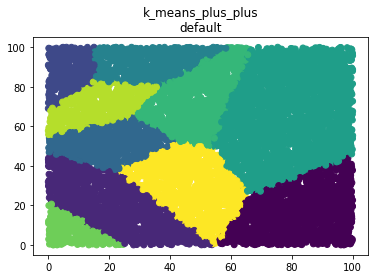

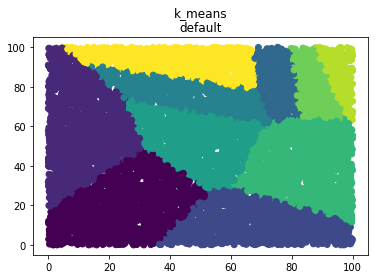

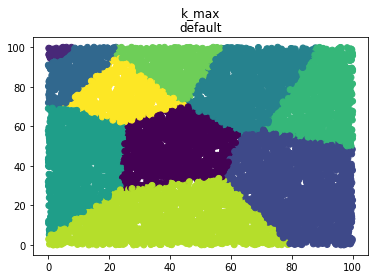

(array([[48.29415676, 61.59043524],
        [77.11244713, 19.53259064],
        [36.99535965, 74.5152359 ],
        ...,
        [73.39870503, 93.44120221],
        [21.38878339, 50.508437  ],
        [80.94810421, 44.036047  ]]),
 array([0., 2., 9., ..., 4., 5., 2.]))

In [122]:
els, clusts = clust(10000, 100, k = 10, show = True, init="k_means_plus_plus")
clust(10000, 100, k = 10, show = True, elements=els, init ="k_means")
clust(10000, 100, k = 10, show = True, elements=els, init = "k_max")

#### Normal random <a id = "normal"></a>

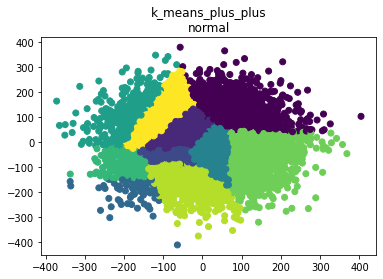

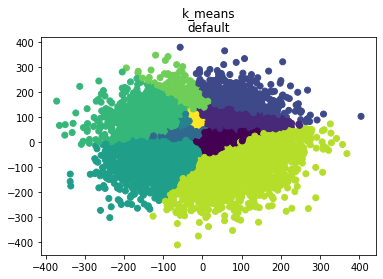

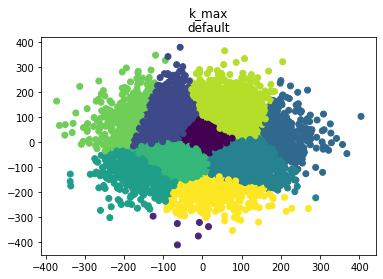

(array([[  35.79105113,   83.70282997],
        [  95.51820902,  -29.75832394],
        [-114.55959553,  -75.7796191 ],
        ...,
        [ 203.45016747,  -83.03679668],
        [ -23.57141723,  131.60960264],
        [ 120.41869916,    9.45095063]]),
 array([8., 4., 6., ..., 4., 2., 4.]))

In [8]:
nels, nclusts = clust(10000, 100, k = 10, show = True, init="k_means_plus_plus", random="normal")
clust(10000, 100, k = 10, show = True, elements=nels, init ="k_means")
clust(10000, 100, k = 10, show = True, elements=nels, init = "k_max")

---
## 2-ое задание (для каких задач подходит, для каких нет) <a id = "2nd"></a>
---
Как было показано ранее на примерах, алгоритм зависит от начальной инициаллизации, и распределяет элементы по кластерам по-разному, поэтому для залач с равномерным распределением данный алгоритм будет работать не очень хорошо.

### Пример для одного и того же набора данных для одной и той же инициаллизации <a id ="incorrect"></a>

#### K_means_plus_plus <a id="k++err"></a>

В данном алгоритме инициаллизация производится по принципу: вероятность выбора точки, как следующего центра пропорциональна вычисленному для неё квадрату расстояния

То есть метод более устойчивый, чем
```python
def k_means(...):
    ...
```

Но все равно кластеризация отличается достаточно сильно.

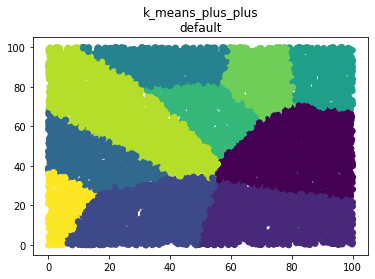

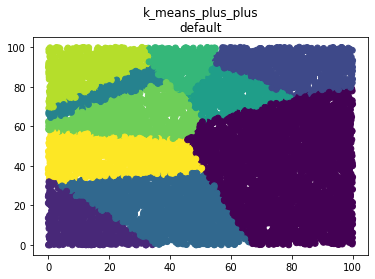

(array([[81.98604676, 88.80538491],
        [13.16539519, 59.01347854],
        [43.50976212,  6.66418214],
        ...,
        [93.64799343, 80.28489168],
        [97.37702965, 35.82039729],
        [44.74301707, 65.7534589 ]]),
 array([2., 7., 3., ..., 2., 0., 7.]))

In [28]:
els, clusts = clust(10000, 100, k = 10, show = True, init="k_means_plus_plus")
clust(10000, 100, k = 10, show = True, elements=els, init ="k_means_plus_plus")

#### K_max <a id="kmerr"></a>

Тоже разные значения, хоть алгоритм и расчитан на то, что соседние кластеры содержат самые удаленные друг от друга элементы, то есть устойчивость не такая, как у `k_means`

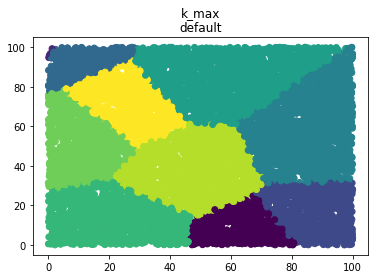

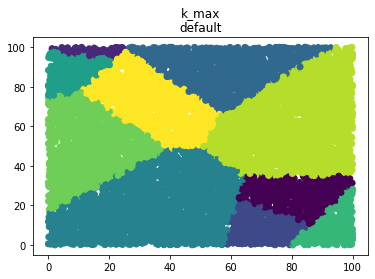

(array([[76.99574398, 45.58674568],
        [84.43109854, 51.08897093],
        [10.64580635, 11.66308972],
        ...,
        [71.14859427, 62.93744476],
        [ 2.48401812, 19.61661239],
        [41.92046837, 50.6451643 ]]),
 array([8., 8., 4., ..., 8., 7., 9.]))

In [10]:
els, clusts = clust(10000, 100, k = 10, show = True, init="k_max")
clust(10000, 100, k = 10, show = True, elements=els, init ="k_max")

#### K_means <a id="kerr"></a>

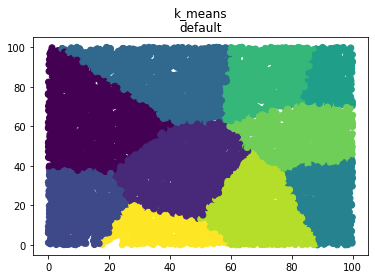

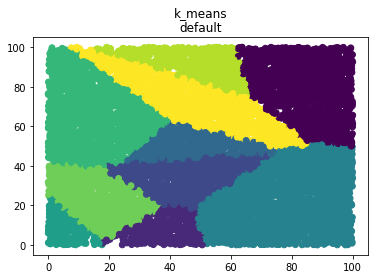

(array([[76.91796802, 71.23373466],
        [65.99638461, 30.68727738],
        [33.22195129, 51.36859075],
        ...,
        [29.62204788, 16.15585035],
        [10.3284122 , 21.49117136],
        [12.95204103, 18.0020907 ]]),
 array([0., 4., 3., ..., 7., 7., 7.]))

In [11]:
els, clusts = clust(10000, 100, k = 10, show = True, init="k_means")
clust(10000, 100, k = 10, show = True, elements=els, init ="k_means")

### Примеры для, которых кластеризация работает достаточно хорошо <a id = "correct"></a>
Для данных, которые разбиваются на k "куч", не пересекаются и не содержатся друг в друге; расстояния между которыми больше "диагонали" этих множеств, алгоритм кластеризирует правильно.

Но важно, какая функция инициализации используется, для данных множеств инициализация `k_max` подходит лучше всего

In [12]:
def heaps(size = 1000):
    elements = np.zeros((size, 2))
    for i in range(elements.shape[0]):
        if i%2:
            elements[i] = np.random.randint(low = 10000, high=20000, size = 2)
        else:
            elements[i] = np.random.randint(low = -20000, high=-10000, size = 2)
    return elements

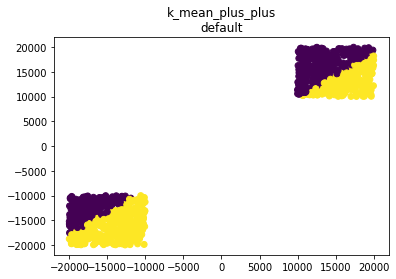

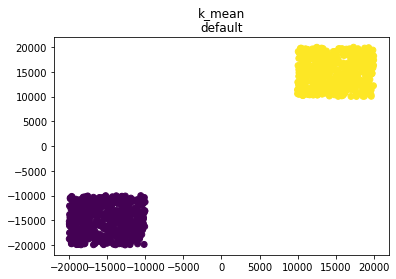

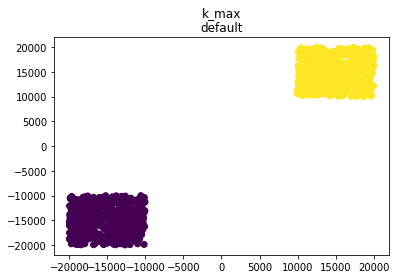

In [202]:
elements = heaps(size = 1000)
els, clusts = clust(elements=elements, show=True, init = "k_mean_plus_plus", k = 2)
els, clusts = clust(elements=elements, show=True, init = "k_mean", k = 2)
els, clusts = clust(elements=elements, show=True, init = "k_max", k = 2)

---
## 3-е задание (стратегия выбора числа кластеров) <a id="3rd"></a>
---

Метод квадратов:
- кластеризируем в цикле, меняя чило кластеров
- после заврешения выбираем то число, для которого сумма квадратов расстояний элементов внтури кластера минимальна и суммарное расстояние между элементами этого и другого кластера максимально
- но можно рассматривать разницу между "внешней" суммой и "внутренней". Если эта разность максимальна, то такое число кластеров - искомое
- максимизируем среднее арифметическое этой разности для всех кластеров

__Оптимизация__:
- считаем расстояния не каждый раз, а только в самом начале, затем просто находим расстояния между элементами через расстояния этих элементов от первоначально выбранного(в приведенном ниже случае `elements[0]`)

Данный способ изменить число операций для вычисления расстояний в цикле от O(N) до O(1), т.е. суммарная сложность останется O(N^2), а не O(N^3).

Стоить отметить, что как в инициализации k_max здесь создание массива попарных расстояний вызовет ошибку для size ~ 10000, но в рассматриваемой задаче число элементов рассматривается меньшее, иначе придется в цикле считать нормы, или же опять использовать погрешности(которые все же много меньше искомого значения).

In [80]:
def num_clusts(elements, max_clusts = 10, init = "k_means_plus_plus"):
    #Started differences
    difs = np.sqrt(((elements[:,None,:] - elements)**2).sum(axis=2))
    max_dif = 0
    ans = 1
    #vectors for vizuallization
    maxs = np.zeros(max_clusts)
    mins = np.zeros(max_clusts)
    for i in range(1, max_clusts):
        els, clusts = clust(elements=elements, init=init, show=False, k = i)
        #current clusters differences for each k in clustering
        tmp_max = np.zeros(i)
        #current difference in cluster for each k
        tmp_min = np.zeros(i)
        for k in range(elements.shape[0]):
            for l in range(elements.shape[0]):
                if clusts[k]==clusts[l]:
                    tmp_min[int(clusts[k])] += difs[l][k]**2
                else:
                    tmp_max[int(clusts[k])] += difs[k][l]**2
        maxs[i] = np.mean(tmp_max)
        mins[i] = np.mean(tmp_min)
        res_dif = np.mean(tmp_max-tmp_min)
        #if more, updates
        if res_dif > max_dif:
            ans = i
            max_dif = res_dif
    #diagrams of max and min: between clusters - blue; in cluster - green
    plt.bar(np.arange(max_clusts)[1:], maxs[1:], color=["blue"])
    plt.bar(np.arange(max_clusts)[1:], mins[1:], color=["green"])
    plt.title("Statistics")
    plt.show()
    
    
    plt.bar(np.arange(max_clusts)[1:], (maxs-mins)[1:], color=["gray"])
    plt.title("Difference")
    plt.show()
    return ans

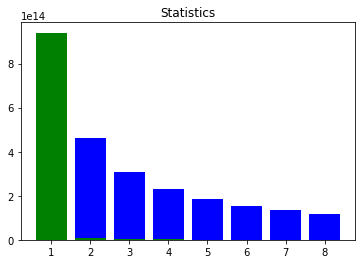

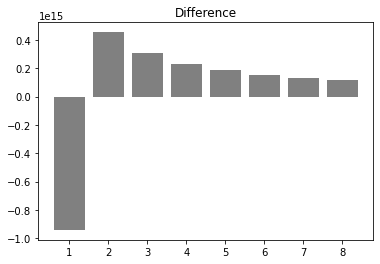

In [81]:
elements = heaps(size = 1000)
ans = num_clusts(elements, max_clusts = 9, init="k_max")

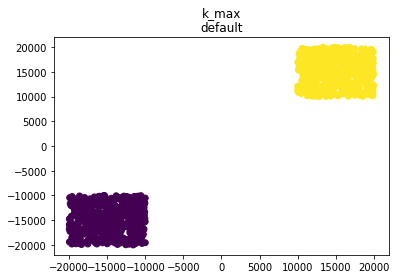

In [16]:
els, cls= clust(elements=elements, k = ans, show = True, init="k_max")

---
## 4-е задание (Зависимость скорости настройки от объема данных/сложности задачи) <a id ="4th"></a>
---

- В этом задании тестирование производилось на множестве с равномерным распределением
- Число итераций изменялось от 0 до 200; 
- Число элементов - от 50 до до 10000, 
- Число кластеров неизменно и равно 5

### Time(num of elements) <a id="te"></a>

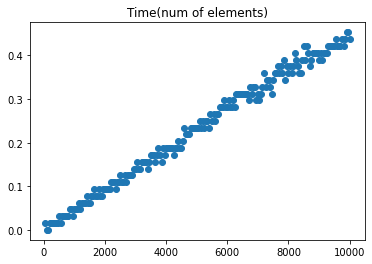

In [96]:
import time

times = np.zeros(201)

for i in range(200):
    #timer start
    start = time.process_time()
    clust((i+1)*50, scale = (i+1)*50)
    #timer end
    times[i+1] = time.process_time() - start
    
plt.scatter(list(map(lambda x: x*50, range(201)))[1:], times[1:])
plt.title("Time(num of elements)")
plt.show()

### Time (num of clusters) <a id="tc"></a>

- Множество элементов не меняется
- Число элементов постоянно и равно 2000
- Число кластеров меняется от 1 до 50
- Распределение равномерное

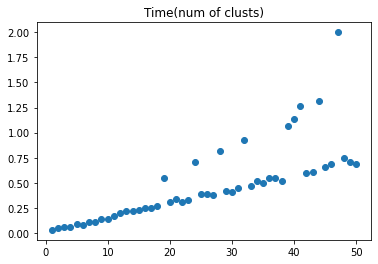

In [44]:
import time

elements, clusts = clust(size=2000, scale=2000, k = 1, init = "k_mean_plus_plus")

times = np.zeros(51)

start = time.process_time()

for i in range(1, 51):
    start = time.process_time()
    clust(elements=elements, k = i, init="k_mean_plus_plus", show=False)
    times[i] = time.process_time() - start
    
plt.scatter(np.arange(51)[1:], times[1:])
plt.title("Time(num of clusts)")
plt.show()

---
## 5-е задание (эвристика визуализации матрицы расстояний и как логичнее упорядочить элементы матрицы расстояний) <a id="5th"></a>
---

Для выполнения этого задания использовался:
- метод оптимизации нахождения расстояния(то есть не вычисление 2-х норм для каждого вектора на каждой итерации, а векторное формирование матрицы расстояний, как в функции [difers](#kmax))

Ниже представлены:
1. Изначальная матрица расстояний
2. Матрица расстояний для элементов, упорядоченных по кластерам
3. Матрица расстояний для элементов, упорядоченных по кластерам, и с упорядоченными кластерами:
    - для i-го кластера следующим в матрице будет тот кластер, который самый удаленный от него
    - предыдущие кластеры сортировать нет необходимости, потому что мы создаем массив из нулей размера `num_of_clusters`, где в каждую позицию пишем самый удаленный от текущего клсатера кластер так, чтобы его индекс не был упомянут прежде.
    - так как изначально массив из нулей, то первый кластер не будет выведен дважды, так как он всегда есть в списке до последнего элемента

### Elements array <a id="elar">

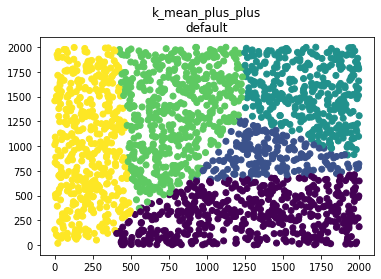

In [178]:
k=5
elements, clusts = clust(size=2000, scale=2000, k = 5, init = "k_mean_plus_plus", show = True)

### Default dist matrix <a id="def"></a>

In [179]:
def default_dist_matrix(els):
    return np.sqrt(((els[:,None,:] - els)**2).sum(axis=2))

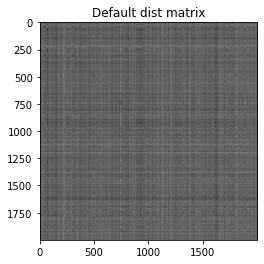

In [180]:
plt.imshow(default_dist_matrix(elements), 'gray', interpolation=None)
plt.title("Default dist matrix")
plt.show()

### Dist matrix after clustering <a id="aftcl"></a>

#### Sorting function <a id="sf"></a>

Множество элементов сортируется так, чтобы сначала в массиве были элементы первого кластера, затем второго и т.д.

In [181]:
def clust_sort(elements, clusts, k):
    new_elements = np.zeros(elements.shape)
    new_clusts = np.zeros(elements.shape[0])
    pos = np.zeros(k)    
    for i in range(k):
        for j in range(elements.shape[0]):
            if clusts[j] == i:
                new_elements[int(pos[i])] = np.array(elements[j])
                new_clusts[int(pos[i])] = i
                pos[i] = pos[i] + 1
        if i < k-1:
            pos[i+1] += pos[i]
    return new_elements, new_clusts

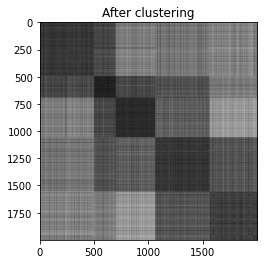

In [182]:
new_elements, new_clusts = clust_sort(elements, clusts, k)
plt.imshow(default_dist_matrix(new_elements), 'gray', interpolation=None)
plt.title("After clustering")
plt.show()

### Sorted clusters dist matrix <a id = "ascl"></a>

#### Sorting clusters <a id = "sort"></a>

- После сортировки элементов по кластерам получаем упорядоченный набор: 1-ый кластер, 2-ой и тд

Сортируем кластеры так, чтобы расстояния между соседними были максимальны
- Возвращаемое значение: массив размера `num_of_clusters` нового порядка кластеров

In [183]:
def sorting_clusters(elements, clusts, k):
    difs = np.sqrt(((elements[:,None,:] - elements)**2).sum(axis=2))
    
    max_difs = np.zeros(k)
    #output array
    indexes = np.zeros(k)
    #for each cluster, find the element farthest from it
    for l in range(k):
        for i in range(elements.shape[0]):
            if clusts[i] != l:
                continue;
                
            max_dist = 0
            #index of the farthes element
            max_ind = 0
            for j in range(elements.shape[0]):
                if difs[j][i] > max_dist and clusts[j] not in indexes:
                    if max_difs[l] < difs[j][i]:
                        indexes[l] = clusts[j]
                        max_difs[l] = difs[j][i]
    return indexes

В таком порядке будем распологать класетры в итоговой матрице

In [192]:
sorted_clusters = sorting_clusters(new_elements, new_clusts, k)
print(sorted_clusters)

[4. 3. 1. 2. 0.]


Теперь в новую матрицу заносим сначала все элементы первого кластера, затем всем элементы кластера номер indexes\[0\] и т.д.

In [194]:
def clust_sort_with_ind(elements, clusts, indexes, k):
    new_elements = np.zeros(elements.shape)
    new_clusts = np.zeros(clusts.shape)
    
    #array of current position for each cluster
    pos = np.zeros(k)
    
    #1st - cluster with index 0
    tmp_ind = 0
    while clusts[tmp_ind] == 0:
        new_elements[int(pos[0])] = np.array(elements[tmp_ind])
        new_clusts[int(pos[0])] = 0
        pos[0] = pos[0] + 1
        tmp_ind += 1
        
    #updating positions
    pos[1] += pos[0]
    for i in range(k-1):
        for j in range(elements.shape[0]):
            #if elements in this cluster(index[i])
            if clusts[j] == indexes[i]:
                #updating elements array and clusters
                new_elements[int(pos[i+1])] = np.array(elements[j])
                new_clusts[int(pos[i+1])] = indexes[i]
                pos[i+1] = pos[i+1] + 1
        #else i+2>=k => error
        if i < k-2:
            pos[i+2] += pos[i+1]
    return new_elements, new_clusts

In [195]:
sorted_elements, sorted_clusts = clust_sort_with_ind(new_elements, new_clusts, indexes=sorted_clusters, k=k)

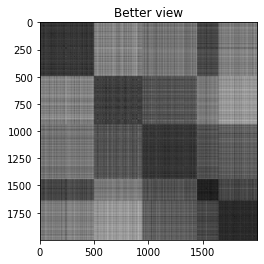

In [196]:
plt.imshow(default_dist_matrix(sorted_elements), 'gray', interpolation=None)
plt.title("Better view")
plt.show()